# Drilling Activity Prediction: Data Modeling - VAR

- Load datasets and resample to monthly frequency
- Use oil dataset to make predictions in oil rig count variable:
    - Train/test split
    - VAR Model Hyperparameter selection
    - Fit the model
    - Invert Transformation
    - Generate forecast values and plot results
    - Evaluation Metrics
    - Fit the model again but with 100% of the data
    - Forecast real future values


- Create Model with Gas dataset to make predictions in Gas Rig Counts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.model_selection import TimeSeriesSplit
import time
from pylab import rcParams
import datetime

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
# Size of all plots
rcParams['figure.figsize'] = 6,6

In [2]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)
dfoil_transformed = pd.read_csv('dfoil_transformed.csv',index_col=0,parse_dates=True)


dfgas = pd.read_csv('dfgas.csv',index_col=0,parse_dates=True)
dfgas_transformed = pd.read_csv('dfgas_transformed.csv',index_col=0,parse_dates=True)

A $K$-dimensional VAR model of order $p$, denoted <strong>VAR(p)</strong>, considers each variable $y_K$ in the system.<br>

For example, The system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

Carrying this further, the system of equations for a 2-dimensional VAR(3) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{11,3}y_{1,t-3} + \phi_{12,3}y_{2,t-3} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{21,3}y_{1,t-3} + \phi_{22,3}y_{2,t-3} + \varepsilon_{2,t}$<br><br>

and the system of equations for a 3-dimensional VAR(2) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{13,1}y_{3,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{13,2}y_{3,t-2} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{23,1}y_{3,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{23,2}y_{3,t-2} + \varepsilon_{2,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{3,t} = c_3 + \phi_{31,1}y_{1,t-1} + \phi_{32,1}y_{2,t-1} + \phi_{33,1}y_{3,t-1} + \phi_{31,2}y_{1,t-2} + \phi_{32,2}y_{2,t-2} + \phi_{33,2}y_{3,t-2} + \varepsilon_{3,t}$<br><br>

In [3]:
"""
This cell is used only to Test model in different points in time
"""
# dfoil = dfoil[:'2016']
# dfoil_transformed = dfoil_transformed[:'2016']
# dfgas = dfgas[:'2016']
# dfgas_transformed = dfgas[:'2016']
freq_time = 'M'
dfoil = dfoil.resample('M').mean()
dfoil.index.freq = 'M'
dfoil_transformed = dfoil_transformed.resample('M').mean()
dfoil_transformed.index.freq = 'M'
dfgas = dfgas.resample('M').mean()
dfgas.index.freq = 'M'
dfgas_transformed = dfgas_transformed.resample('M').mean()
dfgas_transformed.index.freq = 'M'

#### Train/test split

- We will evaluate the model forecasting 12 months ahead (1 year)
- Train test split. Test df will have 12 data points

In [4]:
"""
nobs is the variable that will be used to determine the number of months to predict.
"""

nobs=12
train, test = dfoil_transformed[0:-nobs], dfoil_transformed[-nobs:]

#### Fit VAR model and hyperparameter selection

In [5]:
oil_model = VAR(train)

In [6]:
for i in range(10):
    oil_results = oil_model.fit(i,trend='ctt')
    print('Order =', i)
    print('AIC: ', oil_results.aic)
    print('BIC: ', oil_results.bic)
    print()

Order = 0
AIC:  25.85377895509131
BIC:  26.04552677733711

Order = 1
AIC:  24.625627487008828
BIC:  25.13825754739741

Order = 2
AIC:  24.543052490949258
BIC:  25.378205045457985

Order = 3
AIC:  24.49046824264916
BIC:  25.649797644726515

Order = 4
AIC:  24.44370500807985
BIC:  25.928879877434046

Order = 5
AIC:  24.47985186250436
BIC:  26.29255525647847

Order = 6
AIC:  24.51040237882233
BIC:  26.652331966404212

Order = 7
AIC:  24.560680628038043
BIC:  27.033548866554383

Order = 8
AIC:  24.662155460325025
BIC:  27.467689774869942

Order = 9
AIC:  24.578373424853176
BIC:  27.718316390502856



In [7]:
"""
Choose best AIC based on test done before (4)
"""

oil_results = oil_model.fit(4,trend='ctt')

In [8]:
oil_model.endog_names

['oilrig_count', 'oil_price', 'oilconsumption', 'oilproduction', 'oilstorage']

In [9]:
oil_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 21, Nov, 2021
Time:                     11:00:43
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    25.9289
Nobs:                     282.000    HQIC:                   25.0393
Log likelihood:          -5332.27    FPE:                4.13575e+10
AIC:                      24.4437    Det(Omega_mle):     2.79448e+10
--------------------------------------------------------------------
Results for equation oilrig_count
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.387508         0.281652           -1.376           0.169
trend                     0.007407         0.004572            1.620           0.105
trend**2                 -0.000025   

In [10]:
lag_order = oil_results.k_ar
lag_order

4

#### Generate Forecast values and plot results

- Create forecasts of differenced dataframe
- Transform forecast results into dataframe
- Add datetime index to forecast dataframe
- Invert dataframe transformation
- Plot results and compare Forecasted values Vs Test set

In [11]:
"""
y: Grab the last 4 values (lagged values) before the test set starts in format p x k (series).
steps: amount of steps you want to forecast
"""

z = oil_results.forecast(y=train.values[-lag_order:], steps=nobs)

In [12]:
test.index.min()

Timestamp('2020-11-30 00:00:00', freq='M')

In [13]:
idx = pd.date_range(test.index.min(), periods=nobs, freq='M')
dfoil_forecast = pd.DataFrame(z, index=idx, columns=['oilrig_count2d', 'oil_price2d', 'oilconsumption2d', 'oilproduction2d',
       'oilstorage2d'])

In [14]:
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-nobs-1]-dfoil['oilrig_count'].iloc[-nobs-2])+dfoil_forecast['oilrig_count2d'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-nobs-1] + dfoil_forecast['oilrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Oil Rig Count Prediction: FORECAST vs TEST Set - VAR Model'}>

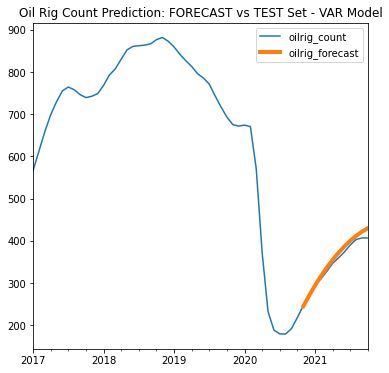

In [15]:
dfoil['oilrig_count'].loc['2017':].plot(legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=4,title='Oil Rig Count Prediction: FORECAST vs TEST Set - VAR Model')

#### Evaluation Metrics

In [16]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MSE1 = mse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MAE1 = meanabs(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])

print(f"""Oil Rig VAR(4) RMSE: {RMSE1:.3f}
Oil Rig VAR(4) MSE: {MSE1:.3f}
Oil Rig VAR(4) MAE: {MAE1:.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

Oil Rig VAR(4) RMSE: 11.013
Oil Rig VAR(4) MSE: 121.297
Oil Rig VAR(4) MAE: 9.293

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 3.192%


In [17]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)
RMSE_oil = []
MSE_oil = []
MAE_oil = []
for train_index, test_index in tscv.split(dfoil_transformed):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train,test = dfoil_transformed.loc[dfoil_transformed.index[train_index],:], dfoil_transformed.loc[dfoil_transformed.index[test_index],:]
    oil_model = VAR(train)
    oil_results = oil_model.fit(4,trend='ctt')
    z = oil_results.forecast(y=train.values[-lag_order:], steps=nobs)
    idx = pd.date_range(test.index.min(), periods=nobs, freq='M')
    dfoil_forecast = pd.DataFrame(z, index=idx, columns=['oilrig_count2d', 'oil_price2d', 'oilconsumption2d', 'oilproduction2d',
           'oilstorage2d'])
    dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-nobs-1]-dfoil['oilrig_count'].iloc[-nobs-2])+dfoil_forecast['oilrig_count2d'].cumsum()
    dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-nobs-1] + dfoil_forecast['oilrig_count1d'].cumsum()
    RMSE_oil.append('{:.3f}'.format(rmse(dfoil.loc[dfoil.index[test_index],'oilrig_count'],dfoil_forecast['oilrig_forecast'])))
    MSE_oil.append('{:.3f}'.format(mse(dfoil.loc[dfoil.index[test_index],'oilrig_count'],dfoil_forecast['oilrig_forecast'])))
    MAE_oil.append('{:.3f}'.format(meanabs(dfoil.loc[dfoil.index[test_index],'oilrig_count'],dfoil_forecast['oilrig_forecast'])))

RMSE_oil = np.array(RMSE_oil).astype('float')
MSE_oil = np.array(MSE_oil).astype('float')
MAE_oil = np.array(MAE_oil).astype('float')
print(f"""\n10-fold Cross Validation Oil Rig
RMSE: {RMSE_oil.mean():.3f},
MSE: {MSE_oil.mean():.3f}
MAE: {MAE_oil.mean():.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE_oil.mean()/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

TRAIN: 178 TEST: 12
TRAIN: 190 TEST: 12
TRAIN: 202 TEST: 12
TRAIN: 214 TEST: 12
TRAIN: 226 TEST: 12
TRAIN: 238 TEST: 12
TRAIN: 250 TEST: 12
TRAIN: 262 TEST: 12
TRAIN: 274 TEST: 12
TRAIN: 286 TEST: 12

10-fold Cross Validation Oil Rig
RMSE: 515.152,
MSE: 382589.856
MAE: 488.906

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 149.296%


#### Fit Model with 100% of Data and forecast Real Future

In [18]:
startTime = time.time()
oil_model = VAR(dfoil_transformed)
oil_results = oil_model.fit(4,trend='ctt')
z = oil_results.forecast(y=dfoil_transformed.values, steps=nobs)
idx = pd.date_range(dfoil_transformed.index.max(), periods=nobs, freq='M')
dfoil_forecast = pd.DataFrame(z, index=idx, columns=['oilrig_count2d', 'oil_price2d', 'oilconsumption2d', 'oilproduction2d',
       'oilstorage2d'])
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-1]-dfoil['oilrig_count'].iloc[-2])+dfoil_forecast['oilrig_count2d'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-1] + dfoil_forecast['oilrig_count1d'].cumsum()
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 0.015956401824951172


<AxesSubplot:title={'center':'Oil Rig Count Prediction: REAL FORECAST - VAR Model'}>

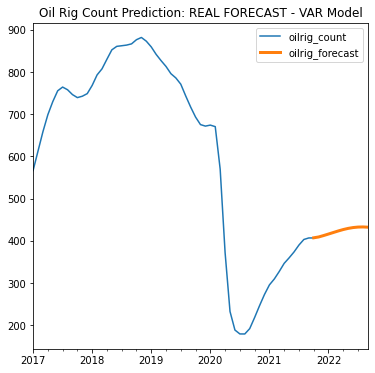

In [19]:
dfoil['oilrig_count'].loc['2017':].plot(legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=3,title='Oil Rig Count Prediction: REAL FORECAST - VAR Model')

#### Create model with Gas Rig Counts

In [20]:
dfgas.columns

Index(['gasrig_count', 'gas_price', 'gaswell_count', 'gasimports_amount',
       'gasconsumption_amount'],
      dtype='object')

In [21]:
train, test = dfgas_transformed[0:-nobs], dfgas_transformed[-nobs:]
gas_model = VAR(train)
gas_results = gas_model.fit(4,trend='ctt')
z2 = gas_results.forecast(y=train.values, steps=nobs)
idx2 = pd.date_range(test.index.min(), periods=nobs, freq='M')
dfgas_forecast = pd.DataFrame(z2, index=idx2, columns=['gasrig_count2d', 'gas_price2d', 'gaswell_count2d', 'gasimports_amount2d',
       'gasconsumption_amount2d'])
dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-nobs-1]-dfgas['gasrig_count'].iloc[-nobs-2])+dfgas_forecast['gasrig_count2d'].cumsum()
dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-nobs-1] + dfgas_forecast['gasrig_count1d'].cumsum()

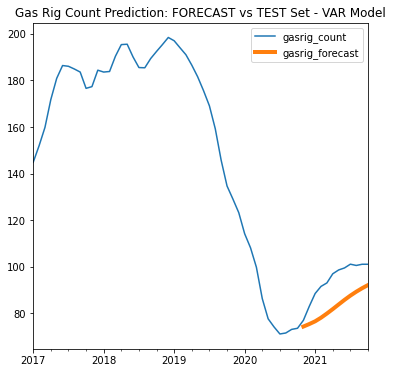

In [22]:
dfgas['gasrig_count'].loc['2017':].plot(legend=True)
dfgas_forecast['gasrig_forecast'].plot(legend=True,linewidth=4,title='Gas Rig Count Prediction: FORECAST vs TEST Set - VAR Model');

In [23]:
RMSE2 = rmse(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])
MSE2 = mse(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])
MAE2 = meanabs(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])

print(f"""Gas Rig VAR(4) RMSE: {RMSE2:.3f}
Gas Rig VAR(4) MSE: {MSE2:.3f}
Gas Rig VAR(4) MAE: {MAE2:.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {(RMSE2/dfgas['gasrig_count'][-nobs:].mean())*100:.3f}%""")

Gas Rig VAR(4) RMSE: 11.890
Gas Rig VAR(4) MSE: 141.381
Gas Rig VAR(4) MAE: 11.385

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 12.615%


In [24]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)
RMSE_gas = []
MSE_gas = []
MAE_gas = []
for train_index, test_index in tscv.split(dfoil_transformed):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train,test = dfgas_transformed.loc[dfgas_transformed.index[train_index],:], dfgas_transformed.loc[dfgas_transformed.index[test_index],:]
    gas_model = VAR(train)
    gas_results = gas_model.fit(4,trend='ctt')
    z = gas_results.forecast(y=train.values[-lag_order:], steps=nobs)
    idx = pd.date_range(test.index.min(), periods=nobs, freq='M')
    dfgas_forecast = pd.DataFrame(z, index=idx, columns=['gasrig_count2d', 'gas_price2d', 'gaswell_count2d', 'gasimports_amount2d',
       'gasconsumption_amount2d'])
    dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-nobs-1]-dfgas['gasrig_count'].iloc[-nobs-2])+dfgas_forecast['gasrig_count2d'].cumsum()
    dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-nobs-1] + dfgas_forecast['gasrig_count1d'].cumsum()
    RMSE_gas.append('{:.3f}'.format(rmse(dfgas.loc[dfgas.index[test_index],'gasrig_count'],dfgas_forecast['gasrig_forecast'])))
    MSE_gas.append('{:.3f}'.format(mse(dfgas.loc[dfgas.index[test_index],'gasrig_count'],dfgas_forecast['gasrig_forecast'])))
    MAE_gas.append('{:.3f}'.format(meanabs(dfgas.loc[dfgas.index[test_index],'gasrig_count'],dfgas_forecast['gasrig_forecast'])))

RMSE_gas = np.array(RMSE_gas).astype('float')
MSE_gas = np.array(MSE_gas).astype('float')
MAE_gas = np.array(MAE_gas).astype('float')
print(f"""\n10-fold Cross Validation Gas Rig
RMSE: {RMSE_gas.mean():.3f},
MSE: {MSE_gas.mean():.3f}
MAE: {MAE_gas.mean():.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE_gas.mean()/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

TRAIN: 178 TEST: 12
TRAIN: 190 TEST: 12
TRAIN: 202 TEST: 12
TRAIN: 214 TEST: 12
TRAIN: 226 TEST: 12
TRAIN: 238 TEST: 12
TRAIN: 250 TEST: 12
TRAIN: 262 TEST: 12
TRAIN: 274 TEST: 12
TRAIN: 286 TEST: 12

10-fold Cross Validation Gas Rig
RMSE: 190.620,
MSE: 66785.434
MAE: 187.414

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 202.240%


RE-Fit model with 100% of data for TRUE Forecasting

In [25]:
gas_model = VAR(dfgas_transformed)
gas_results = gas_model.fit(4,trend='ctt')
z = gas_results.forecast(y=dfgas_transformed.values, steps=nobs)
idx = pd.date_range(dfgas_transformed.index.max(), periods=nobs, freq='M')
dfgas_forecast = pd.DataFrame(z, index=idx, columns=['gasrig_count2d', 'gas_price2d', 'gaswell_count2d', 'gasimports_amount2d',
       'gasconsumption_amount2d'])
dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-1]-dfgas['gasrig_count'].iloc[-2])+dfgas_forecast['gasrig_count2d'].cumsum()
dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-1] + dfgas_forecast['gasrig_count1d'].cumsum()

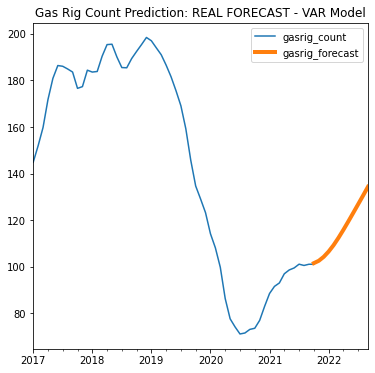

In [26]:
dfgas['gasrig_count'].loc['2017':].plot(legend=True)
dfgas_forecast['gasrig_forecast'].plot(legend=True,linewidth=4,title='Gas Rig Count Prediction: REAL FORECAST - VAR Model');